# Testando se as séries temporais são estacionárias

## Bitcoin + Ethereum + Notícias

https://machinelearningmastery.com/time-series-data-stationary-python/

https://medium.com/swlh/using-granger-causality-test-to-know-if-one-time-series-is-impacting-in-predicting-another-6285b9fd2d1c

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322

https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638

Séries temporais são diferentes de problemas de modelagem mais tradicionais, como classificação ou regressão. A estrutura temporal impõe uma ordem nas observações, que deve ser levada em conta na modelagem. Isso se refere às estatísticas da série temporal, que devem ser consistentes durante todo o período observado. Essa consistência é chamada de estacionariedade. A estacionaridade está ausente em séries temporais que tem uma sazonalidade ou uma tendência, ou qualquer estrutura de dados que dependem do tempo. Portanto, uma série temporal tem que ser estacionária para ser modelada.

Um conceito importanto é que a modelagem assume que a série temporal foi produzida por um processo estocástico. Se houver sazonalidade, é necessário modelar apenas os resíduos da série.

Neste notebook, vou começar fazendo algumas visualizações dos dados. Depois, vou aplicar o Augmented Dickey-Fuller Test of Stationary. Caso as séries não sejam estacionárias, vou aplicar uma diferenciação e testar novamente para confirmar a estacionariedade da série.

In [1]:
import requests
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler

#dados
import yfinance as yf
from pytrends.request import TrendReq

#gráficos
import plotly.graph_objs as go 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

In [2]:
# download dos dados Bitcoin + Ethereum dos últimos 4 anos com intevalo de 1 dia
data = yf.download(tickers='BTC-USD', period = '4y', interval = '1d')
dataBTC = pd.DataFrame(data['Close'])
dataBTC.columns = ['BTC']

data = yf.download(tickers='ETH-USD', period = '4y', interval = '1d')
dataETH = pd.DataFrame(data['Close'])
dataETH.columns = ['ETH']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# combinando preço Bitcoin + preço Ethereum
data_cripto = pd.concat([dataBTC, dataETH], axis=1).dropna(how='any')
data_cripto.head()

,BTC,ETH
Date,,
2017-07-13,2357.899902,209.733002
2017-07-14,2233.340088,199.662003
2017-07-15,1998.859985,170.654999
2017-07-16,1929.819946,157.363007
2017-07-17,2228.409912,193.423996


In [4]:
sc_x = StandardScaler()

#Bitcoin + Ethereum
data_cripto['BTC'] = sc_x.fit_transform(data_cripto['BTC'].values.reshape(-1,1))
data_cripto['ETH'] = sc_x.fit_transform(data_cripto['ETH'].values.reshape(-1,1))

In [5]:
rcParams['figure.figsize'] = 16,9

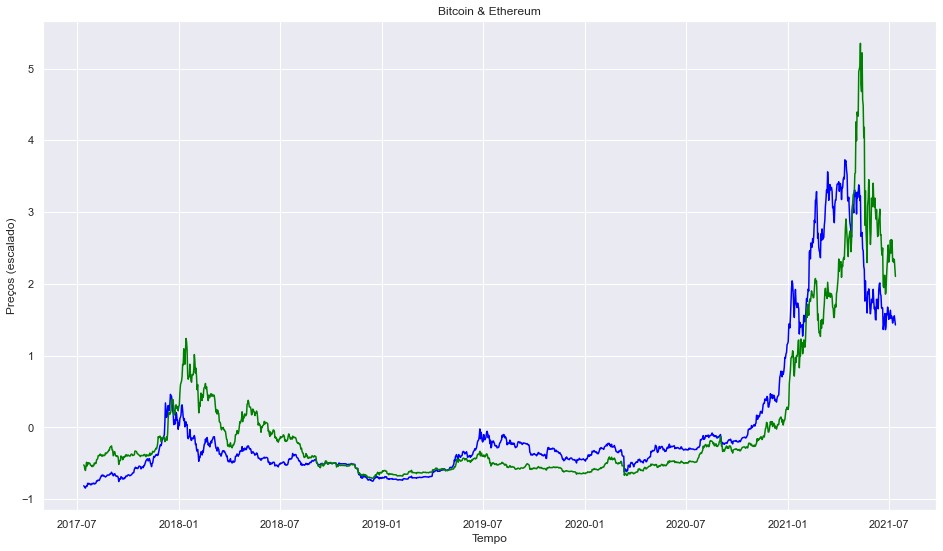

In [6]:
sns.set()
plt.plot(data_cripto.index, data_cripto['BTC'], color='blue')
plt.plot(data_cripto.index, data_cripto['ETH'], color='green')

plt.xlabel('Tempo')
plt.ylabel('Preços (escalado)')
plt.title('Bitcoin & Ethereum')
plt.show()

- Não existe tendências obvias ou sazonalidade nestas séries temporais. No entando, nem sempre é possível verificar a estacionariedade visualmente. Portanto faremos os testes estatísticos para obter a resposta.

In [7]:
from datetime import datetime, timezone
from collections import OrderedDict
from collections import defaultdict

In [8]:
# para os próximos gráficos, vou usar dados não estandarizados

data_cripto1 = pd.concat([dataBTC, dataETH], axis=1).dropna(how='any')

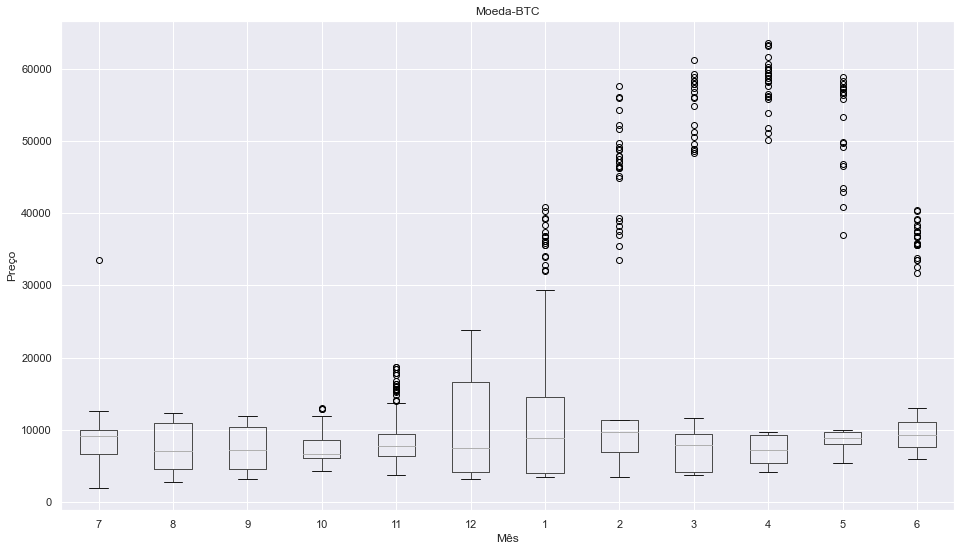

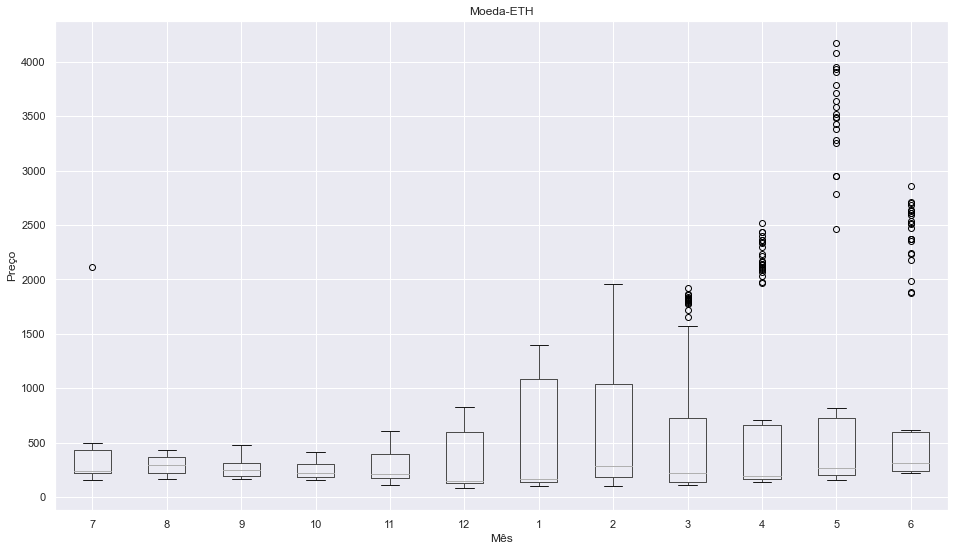

In [10]:
#Boxplot da variação de cada mês por ano para cada moeda

for coin in data_cripto1:    
    group = OrderedDict.fromkeys(data_cripto1[coin].index.month)
    group = defaultdict(list)
    for i in data_cripto1[coin].index:
        group[i.month].append(data_cripto1[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    month = pd.DataFrame()
    for key, value in group.items():
        month[key] = value[:min_len]
    

    month.boxplot()
    plt.ylabel('Preço')
    plt.xlabel('Mês')
    plt.title('Moeda-{}'.format(coin), loc='center')
    plt.savefig('boxplot_coin.png', dpi=300)
    plt.show()

- Aqui fiz um boxplot da variação de cada mês para cada moeda e possível ver que nas duas moedas as médias se mantém estáveis durante o ano, mas alguns meses tem grandes variações de preços, com muito outliers durante os primeiros meses do ano.

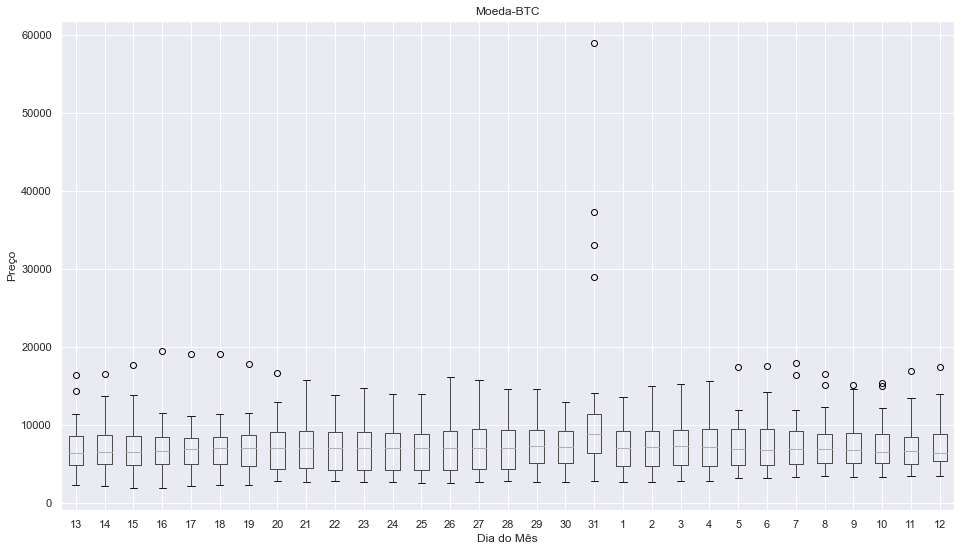

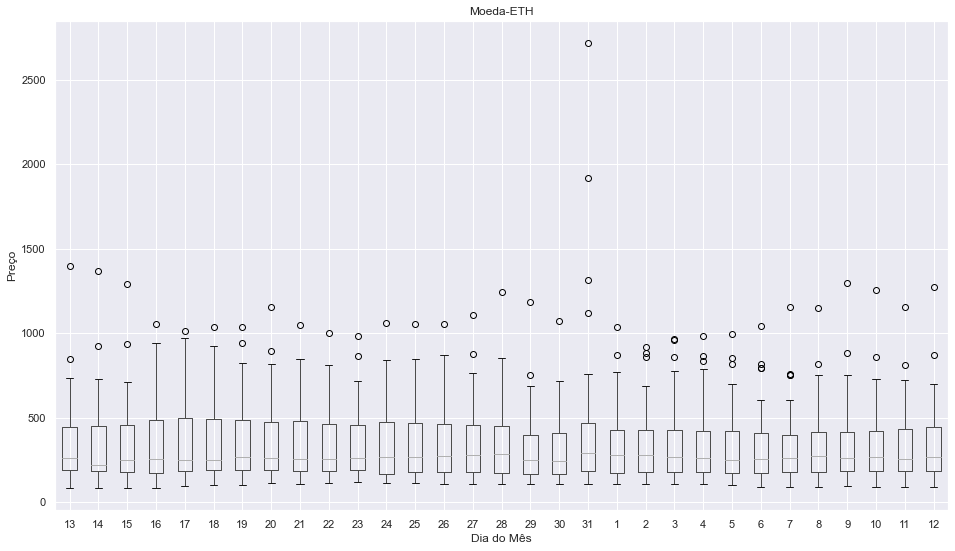

In [11]:
#Boxplot da variação do dia do mês para cada moeda

for coin in data_cripto1:    
    group = OrderedDict.fromkeys(data_cripto1[coin].index.day)
    group = defaultdict(list)
    for i in data_cripto1[coin].index:
        group[i.day].append(data_cripto1[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    day = pd.DataFrame()
    for key, value in group.items():
        day[key] = value[:min_len]
    

    day.boxplot()
    plt.ylabel('Preço')
    plt.xlabel('Dia do Mês')
    plt.title('Moeda-{}'.format(coin), loc='center')
    plt.savefig('boxplot_d_coin.png', dpi=300)
    plt.show()

- Aqui fiz um boxplot da variação de cada dia do mês para cada moeda e possível ver que nas duas moedas as médias se mantém estáveis durante o mês. Durante o período analisado, Etherem apresenta mais variação de preços e mais outliers do que o Bitcoin.

## Decomposição Aditiva

https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453

### Bitcoin

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

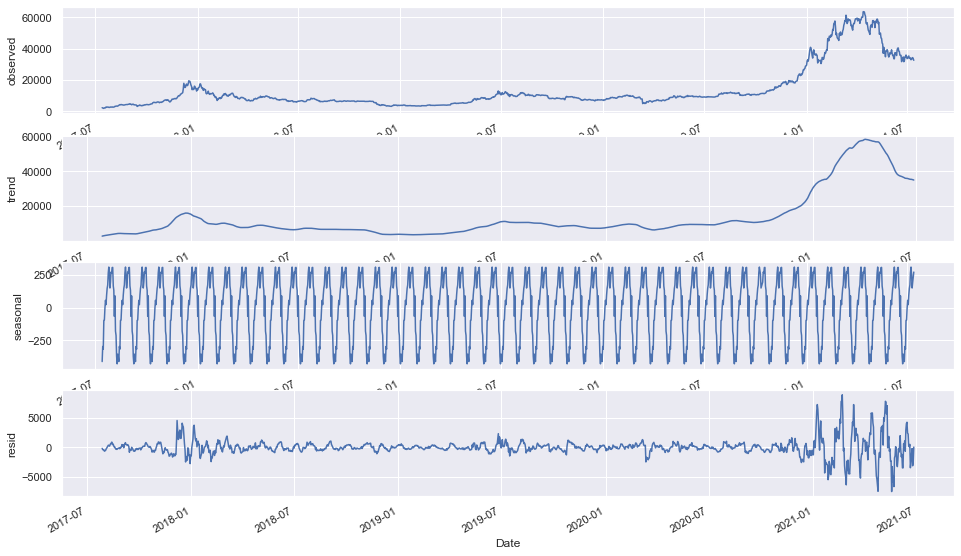

In [15]:
# Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.
decompositionBTC = seasonal_decompose(dataBTC, period=30) #period: 30 dias no mês

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decompositionBTC.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decompositionBTC.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decompositionBTC.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decompositionBTC.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

plt.savefig('dec_BTC.png', dpi=300)
plt.show()

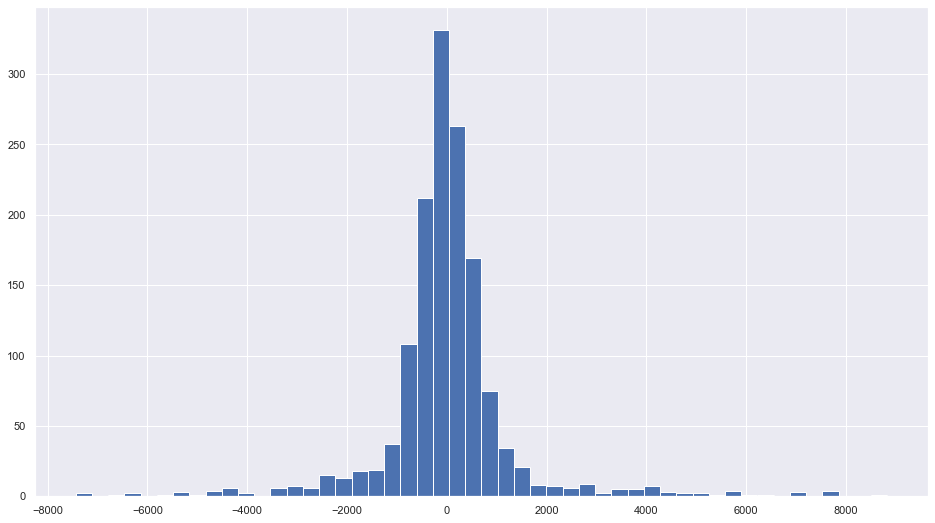

In [16]:
# Vamos analisar a componente de resíduo com um pouco mais de cuidado:
decompositionBTC.resid.hist(bins=50);

plt.savefig('res_BTC.png', dpi=300)
plt.show()

### Ethereum

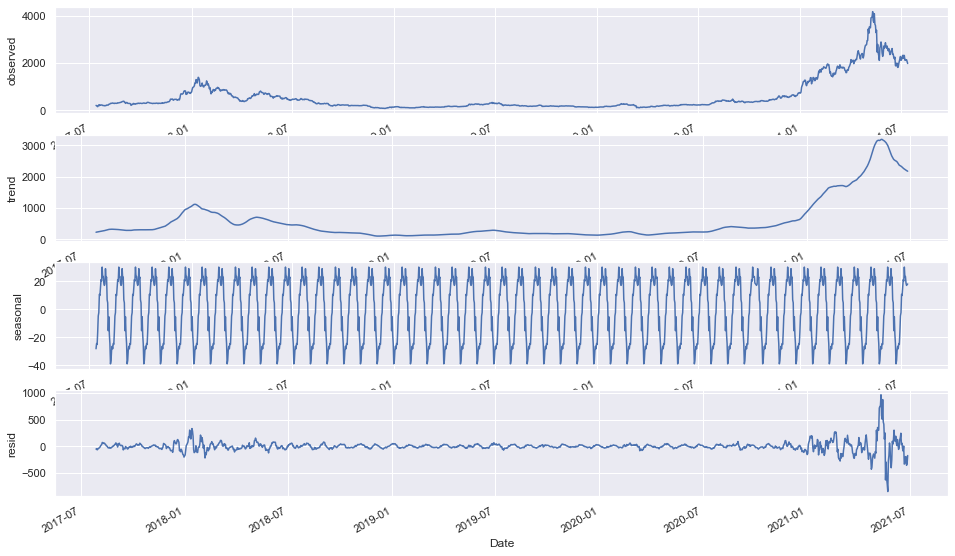

In [17]:
decompositionETH = seasonal_decompose(dataETH, period=30) #period: 30 dias no mês

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decompositionETH.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decompositionETH.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decompositionETH.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decompositionETH.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

plt.savefig('dec_ETH.png', dpi=300)
plt.show()

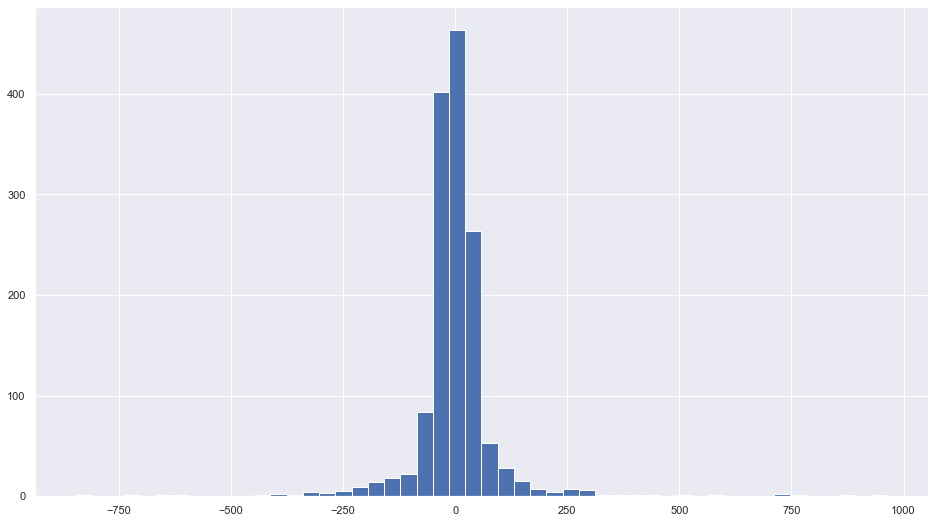

In [18]:
decompositionETH.resid.hist(bins=50);

plt.savefig('res_ETH.png', dpi=300)
plt.show()

## Augmented Dickey-Fuller Test of Stationary

A abordagem mais rigorosa para detectar estacionariedade em dados de séries temporais é usar testes estatísticos desenvolvidos para detectar tipos específicos de estacionariedade.

O teste de Dickey-Fuller foi o primeiro teste estatístico desenvolvido para testar a hipótese nula de que uma raiz unitária está presente em um modelo autorregressivo de uma série temporal e, portanto, o processo não é estacionário.

A hipótese nula é que o série temporal é não estacionária. Portanto se o valor de p é menor que 0.05, a hipótese nula poderia ser rejeitada. Neste caso, o melhor seria rejeitar a hipótese nula, já que isso indicaria que a série temporal é estacionária e poderia ser usada para modelos sem a aplicação de diferenciação.

Para ficar mais claro:
- Hipótese nula (H0): sugere que a série temporal tem uma raiz unitária, que significa que não é estacionária. A série temporal tem um estrutura temporal dependente.
- Hipótese alternativa (H1): a hipótese nula é rejeitada; sugere que a série temporal não tem uma raiz unitária, o que significa que é estacionária. A série temporal não tem uma estrutura dependente do tempo e é produzida estocasticamente.

In [19]:
# Dickey Fuller Test para determinar se as séries são estacionárias

from statsmodels.tsa.stattools import adfuller

x = data_cripto1['ETH'].values
DF_ETH = adfuller(x)

print('\n')
print('\033[1m' + 'Result 1' + '\033[0m')
print('ADF Statistic (ETH): %f' % DF_ETH[0])
print('p-value: %f' % DF_ETH[1])
print('Critical Values:')
for key, value in DF_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

y = data_cripto1['BTC'].values
DF_BTC = adfuller(y)

print('\n')
print('ADF Statistic (BTC): %f' % DF_BTC[0])
print('p-value: %f' % DF_BTC[1])
print('Critical Values:')
for key, value in DF_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 1
ADF Statistic (ETH): -0.501710
p-value: 0.891682
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


ADF Statistic (BTC): -0.882643
p-value: 0.793635
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568




- O resultado do teste Dickey-Fuller mostra que tanto ETH quanto BTC não são estacionárias. A hipótese nula não foi rejeitada.
- Para tornar a série estacionária, podemos utilizar o método da diferenciação.

## Diferenciação

Este é um método popular usado para estacionarizar séries temporais. Ele pode ser usado para remover tendências e sazonalidade. Se uma série temporal tiver um componente sazonal, o valor da defasagem deve ser o período da sazonalidade. Em nosso caso, não há um componente sazonal óbvio. Podemos ver nos gráficos de boxplot acima que a média mês/dia do Bitcoin e do Ethereum são relativamente constantes ao longo do tempo. 

In [20]:
# fazer a diferenciação das séries

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# difference the dataset
diff_BTC = difference(data_cripto1['BTC'])
diff_ETH = difference(data_cripto1['ETH'])

# invert differenced forecast #
#def inverse_difference(last_ob, value):
#    return value + last_ob
# invert the difference #
#inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]
#print(inverted)

Agora fazemos no teste Dickey-Fuller novamente.

In [21]:
# Fazer o Teste Dickey-Fuller nas séries diferenciadas

DF_diff_BTC = adfuller(diff_BTC)
print('\n')
print('\033[1m' + 'Result 2' + '\033[0m')
print('ADF Statistic (BTC): %f' % DF_diff_BTC[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH = adfuller(diff_ETH)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 2
ADF Statistic (BTC): -7.294550
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


ADF Statistic (ETH): -11.600603
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568




- o resultado mostra um valor de p menor do que 0.05 nas duas moedas, rejeitando a hipótese nula.
- depois da diferenciação, a série temporal pode ser utilizada para modelagem, já que reduzimos as sazonalidades ou tendências.

## Granger test

In [22]:
# Result 3- Perfrom Granger Causality Test with the null hypothesis of ETH doesn't Granger cause BTC

import statsmodels.tsa.stattools as sm
diff_BTC_ETH = pd.DataFrame()
diff_BTC_ETH['BTC'] = diff_BTC
diff_BTC_ETH['ETH'] = diff_ETH
print('Resultado')
cor = sm.grangercausalitytests(diff_BTC_ETH, 12)

Resultado

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=52.6141 , p=0.0000  , df_denom=1452, df_num=1
ssr based chi2 test:   chi2=52.7228 , p=0.0000  , df=1
likelihood ratio test: chi2=51.7901 , p=0.0000  , df=1
parameter F test:         F=52.6141 , p=0.0000  , df_denom=1452, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=28.1530 , p=0.0000  , df_denom=1449, df_num=2
ssr based chi2 test:   chi2=56.5003 , p=0.0000  , df=2
likelihood ratio test: chi2=55.4302 , p=0.0000  , df=2
parameter F test:         F=28.1530 , p=0.0000  , df_denom=1449, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.2830 , p=0.0000  , df_denom=1446, df_num=3
ssr based chi2 test:   chi2=58.1291 , p=0.0000  , df=3
likelihood ratio test: chi2=56.9965 , p=0.0000  , df=3
parameter F test:         F=19.2830 , p=0.0000  , df_denom=1446, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=14.9

In [23]:
# Result 4- Perform Granger Causality Test with the null hypothesis of BTC doesn't Granger cause ETH

diff_ETH_BTC = pd.DataFrame()
diff_ETH_BTC['ETH'] = diff_ETH
diff_ETH_BTC['BTC'] = diff_BTC
print('Resultado')
cor = sm.grangercausalitytests(diff_ETH_BTC, 12)

Resultado

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9888 , p=0.0009  , df_denom=1452, df_num=1
ssr based chi2 test:   chi2=11.0115 , p=0.0009  , df=1
likelihood ratio test: chi2=10.9701 , p=0.0009  , df=1
parameter F test:         F=10.9888 , p=0.0009  , df_denom=1452, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.2669  , p=0.0001  , df_denom=1449, df_num=2
ssr based chi2 test:   chi2=18.5978 , p=0.0001  , df=2
likelihood ratio test: chi2=18.4798 , p=0.0001  , df=2
parameter F test:         F=9.2669  , p=0.0001  , df_denom=1449, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7387  , p=0.0000  , df_denom=1446, df_num=3
ssr based chi2 test:   chi2=26.3432 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1072 , p=0.0000  , df=3
parameter F test:         F=8.7387  , p=0.0000  , df_denom=1446, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.26